In [1]:
import pandas as pd
import numpy as np
RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

import tensorflow as tf
np.random.seed(RSEED)
tf.random.set_seed(RSEED)
np.random.seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier


import sys 
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import warnings
warnings.filterwarnings("ignore")


2023-11-14 13:19:51.402940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


### Read the datasets 

In [2]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled.npy')

static = pd.read_csv('preprocessing/representations/static_eq.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df.csv')
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')


folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')


In [3]:
#static = static.fillna(-1)
static = static.set_index('icustay_id')
static = static.loc[:, static.gt(0).mean() >= .1]  

static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
    'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
    'cardiac_arrhythmias', 'hypertension', 'other_neurological',
    'chronic_pulmonary',  'hypothyroidism',
    'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
    'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
    'circulatory_infectious_congenital', 'nervous_and_sense',
    'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
    'mental']]

In [4]:
time_series_2d.shape

(5784, 24, 47)

In [5]:
time_series_3d.shape

(5784, 24, 47)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')
time_series_2d_df.shape

(5784, 47)

In [7]:

static.shape

(5784, 30)

In [8]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Cluster

In [9]:
## load the encoded representations
static = static.fillna(0)
path = f'results_EQ/saved_models' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(3)_EQ', path)

181/181 [==============================] - 1s 1ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 2s 6ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 2s 7ms/step
MM SHAPE: (5784, 10)


In [78]:
from tqdm import tqdm

path = f'results_EQ/saved_models_avg' 
num_runs = 15
all_encoded_static = []
all_encoded_time_series = []
all_encoded_mm = []

for run in tqdm(range(num_runs), desc="Training Autoencoders"):
    current_seed = RSEED + run  # Use a different seed for each run
    tf.random.set_seed(current_seed)
    np.random.seed(current_seed)
    print(run, current_seed)

    latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, f'latent_avg_{run}', path)
    all_encoded_static.append(latent_st)
    all_encoded_time_series.append(latent_ts)
    all_encoded_mm.append(latent_mm)
    
# Compute the average of the encoded representations
average_encoded_static = np.mean(all_encoded_static, axis=0)
average_encoded_time_series = np.mean(all_encoded_time_series, axis=0)
average_encoded_mm = np.mean(all_encoded_mm, axis=0)

Training Autoencoders:   0%|          | 0/15 [00:00<?, ?it/s]

0 42
181/181 [==============================] - 1s 3ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 9ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 9ms/step


Training Autoencoders:   7%|▋         | 1/15 [00:11<02:38, 11.35s/it]

MM SHAPE: (5784, 10)
1 43
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  13%|█▎        | 2/15 [00:20<02:09,  9.93s/it]

MM SHAPE: (5784, 10)
2 44
181/181 [==============================] - 0s 1ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 4s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 10ms/step


Training Autoencoders:  20%|██        | 3/15 [00:30<02:00, 10.01s/it]

MM SHAPE: (5784, 10)
3 45
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 9ms/step


Training Autoencoders:  27%|██▋       | 4/15 [00:40<01:49,  9.96s/it]

MM SHAPE: (5784, 10)
4 46
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  33%|███▎      | 5/15 [00:50<01:38,  9.89s/it]

MM SHAPE: (5784, 10)
5 47
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  40%|████      | 6/15 [00:59<01:26,  9.62s/it]

MM SHAPE: (5784, 10)
6 48
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 9ms/step


Training Autoencoders:  47%|████▋     | 7/15 [01:10<01:22, 10.29s/it]

MM SHAPE: (5784, 10)
7 49
181/181 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 5s 11ms/step


Training Autoencoders:  53%|█████▎    | 8/15 [01:23<01:16, 10.93s/it]

MM SHAPE: (5784, 10)
8 50
181/181 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  60%|██████    | 9/15 [01:33<01:03, 10.66s/it]

MM SHAPE: (5784, 10)
9 51
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 4s 8ms/step


Training Autoencoders:  67%|██████▋   | 10/15 [01:42<00:50, 10.17s/it]

MM SHAPE: (5784, 10)
10 52
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  73%|███████▎  | 11/15 [01:50<00:38,  9.58s/it]

MM SHAPE: (5784, 10)
11 53
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  80%|████████  | 12/15 [01:58<00:27,  9.24s/it]

MM SHAPE: (5784, 10)
12 54
181/181 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 8ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step


Training Autoencoders:  87%|████████▋ | 13/15 [02:07<00:18,  9.15s/it]

MM SHAPE: (5784, 10)
13 55
181/181 [==============================] - 0s 1ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 7ms/step


Training Autoencoders:  93%|█████████▎| 14/15 [02:16<00:09,  9.12s/it]

MM SHAPE: (5784, 10)
14 56
181/181 [==============================] - 0s 1ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 2s 6ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 2s 7ms/step


Training Autoencoders: 100%|██████████| 15/15 [02:24<00:00,  9.60s/it]

MM SHAPE: (5784, 10)



## Baselines


In [10]:
# bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

# #time series should be false
# best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
#     clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, time_series_2d_df, bool_list, 'BASELINE', max_clusters=10)

## Comparison of fusions 

KMeans
SPectral
DBSCAN
{'min_cluster_size': 77, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: Agglomerative
4     661
3     532
14    524
1     484
6     452
2     420
12    419
15    325
13    312
9     280
0     261
5     225
8     203
7     200
10    166
16    165
11    155
dtype: int64
 0    2661
 1    2346
-1     777
dtype: int64
0    2563
1    1960
2    1261
dtype: int64


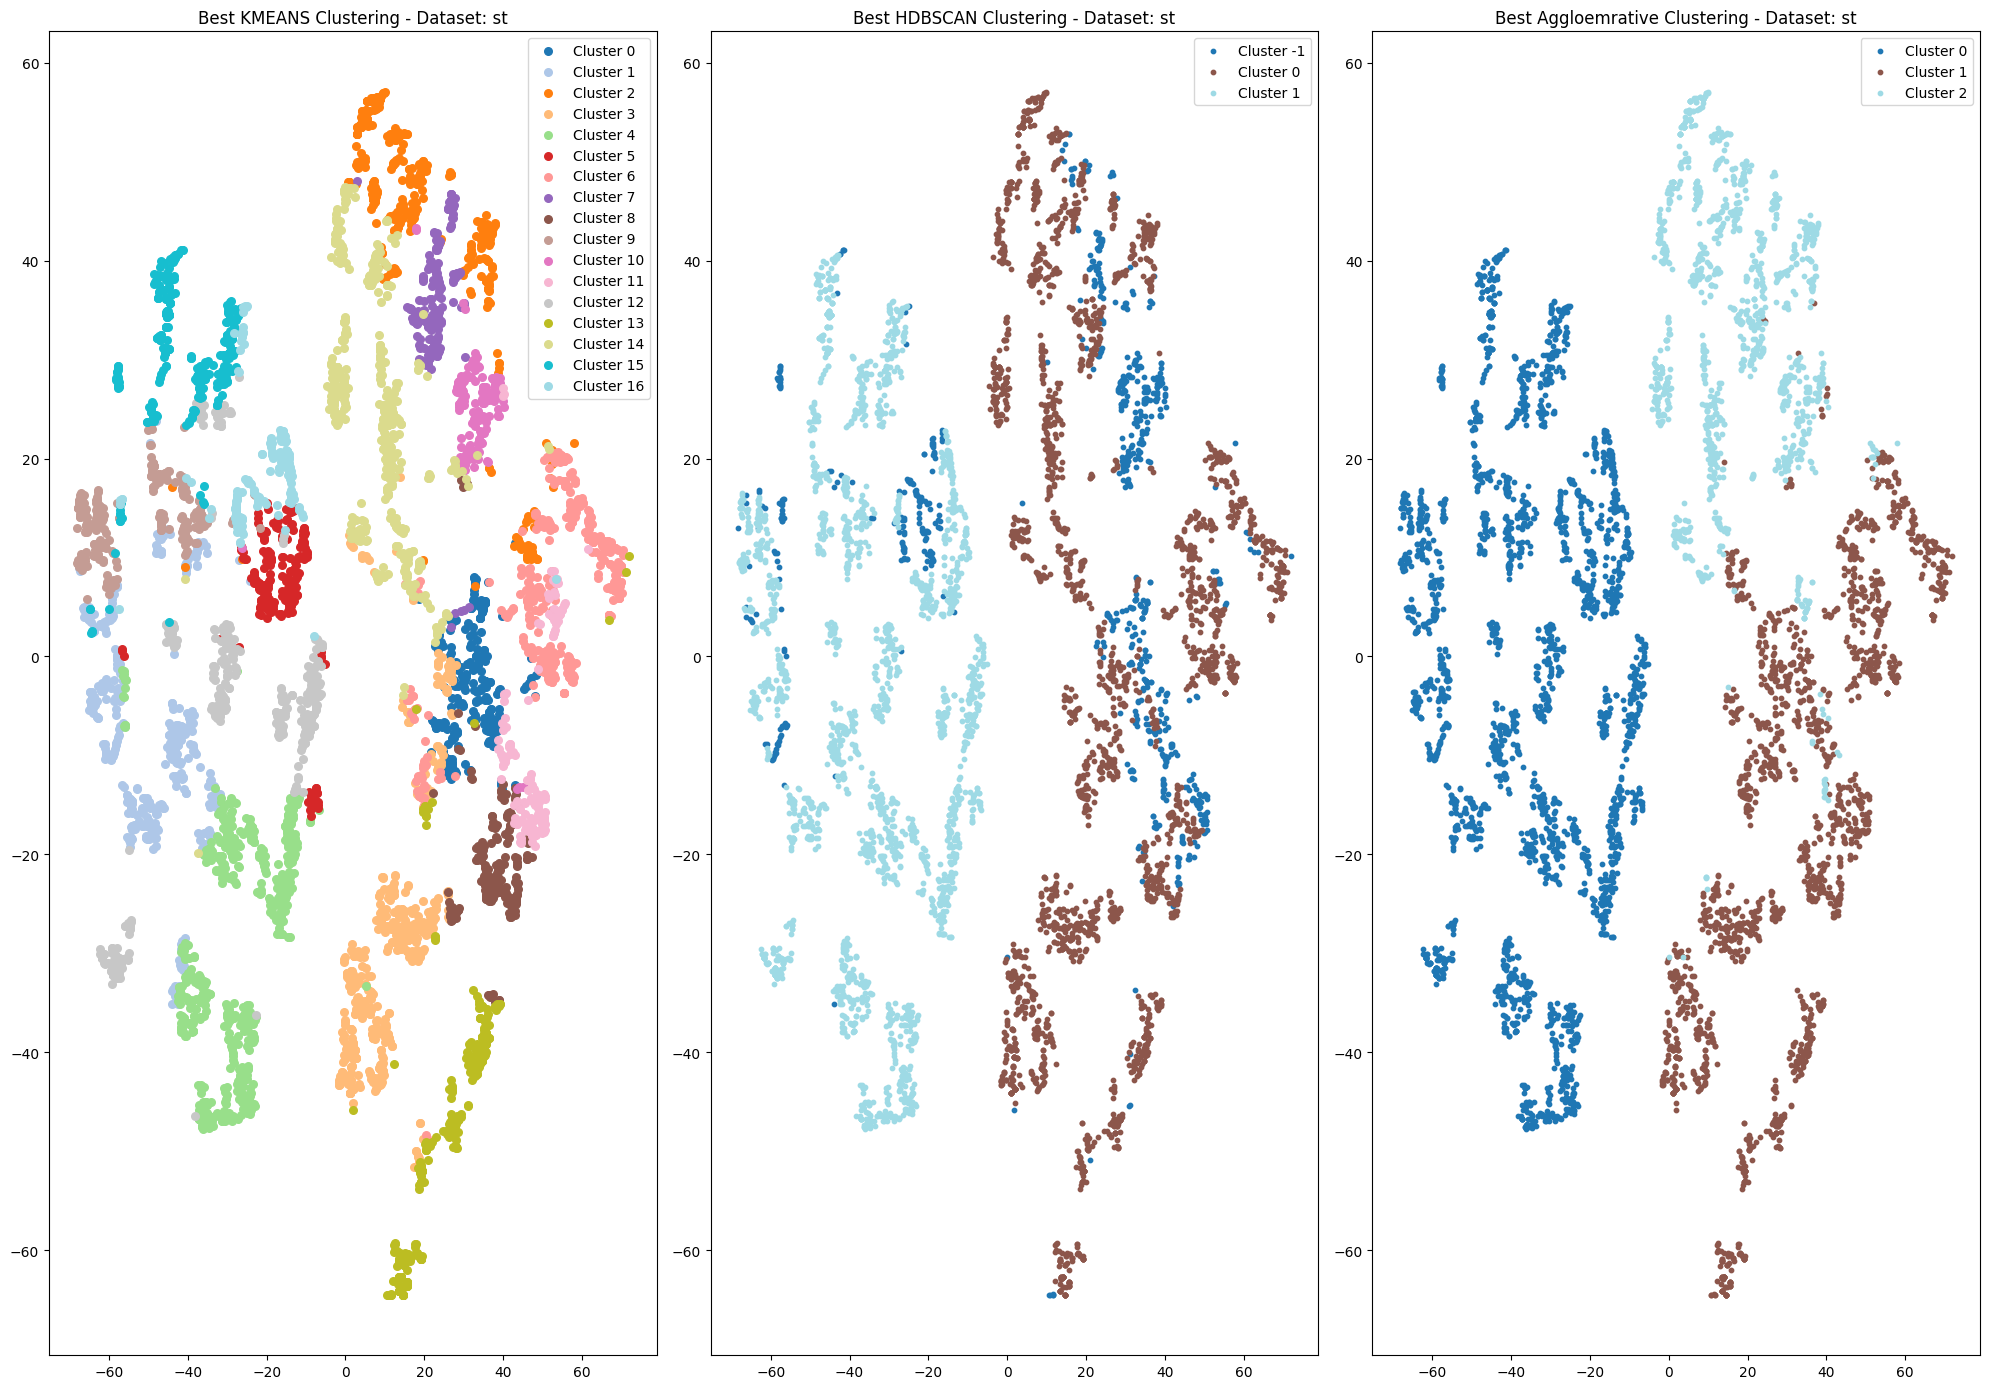

KMeans
SPectral
DBSCAN
{'min_cluster_size': 61, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: Agglomerative
1     474
3     441
15    380
11    368
16    332
5     327
13    326
0     321
14    305
6     292
8     276
2     262
4     217
20    207
17    202
18    196
19    183
10    181
12    181
7     163
9     150
dtype: int64
-1     1518
 5      290
 1      284
 21     276
 2      269
 22     239
 16     231
 11     219
 20     201
 13     193
 25     170
 26     166
 23     165
 12     157
 3      153
 15     133
 7      129
 9      127
 18     113
 8      112
 10     106
 6      105
 24      79
 19      77
 17      71
 4       70
 14      69
 0       62
dtype: int64
95    290
50    279
4     267
14    156
59    156
     ... 
41     15
93     14
63     13
94     12
82      9
Length: 100, dtype: int64


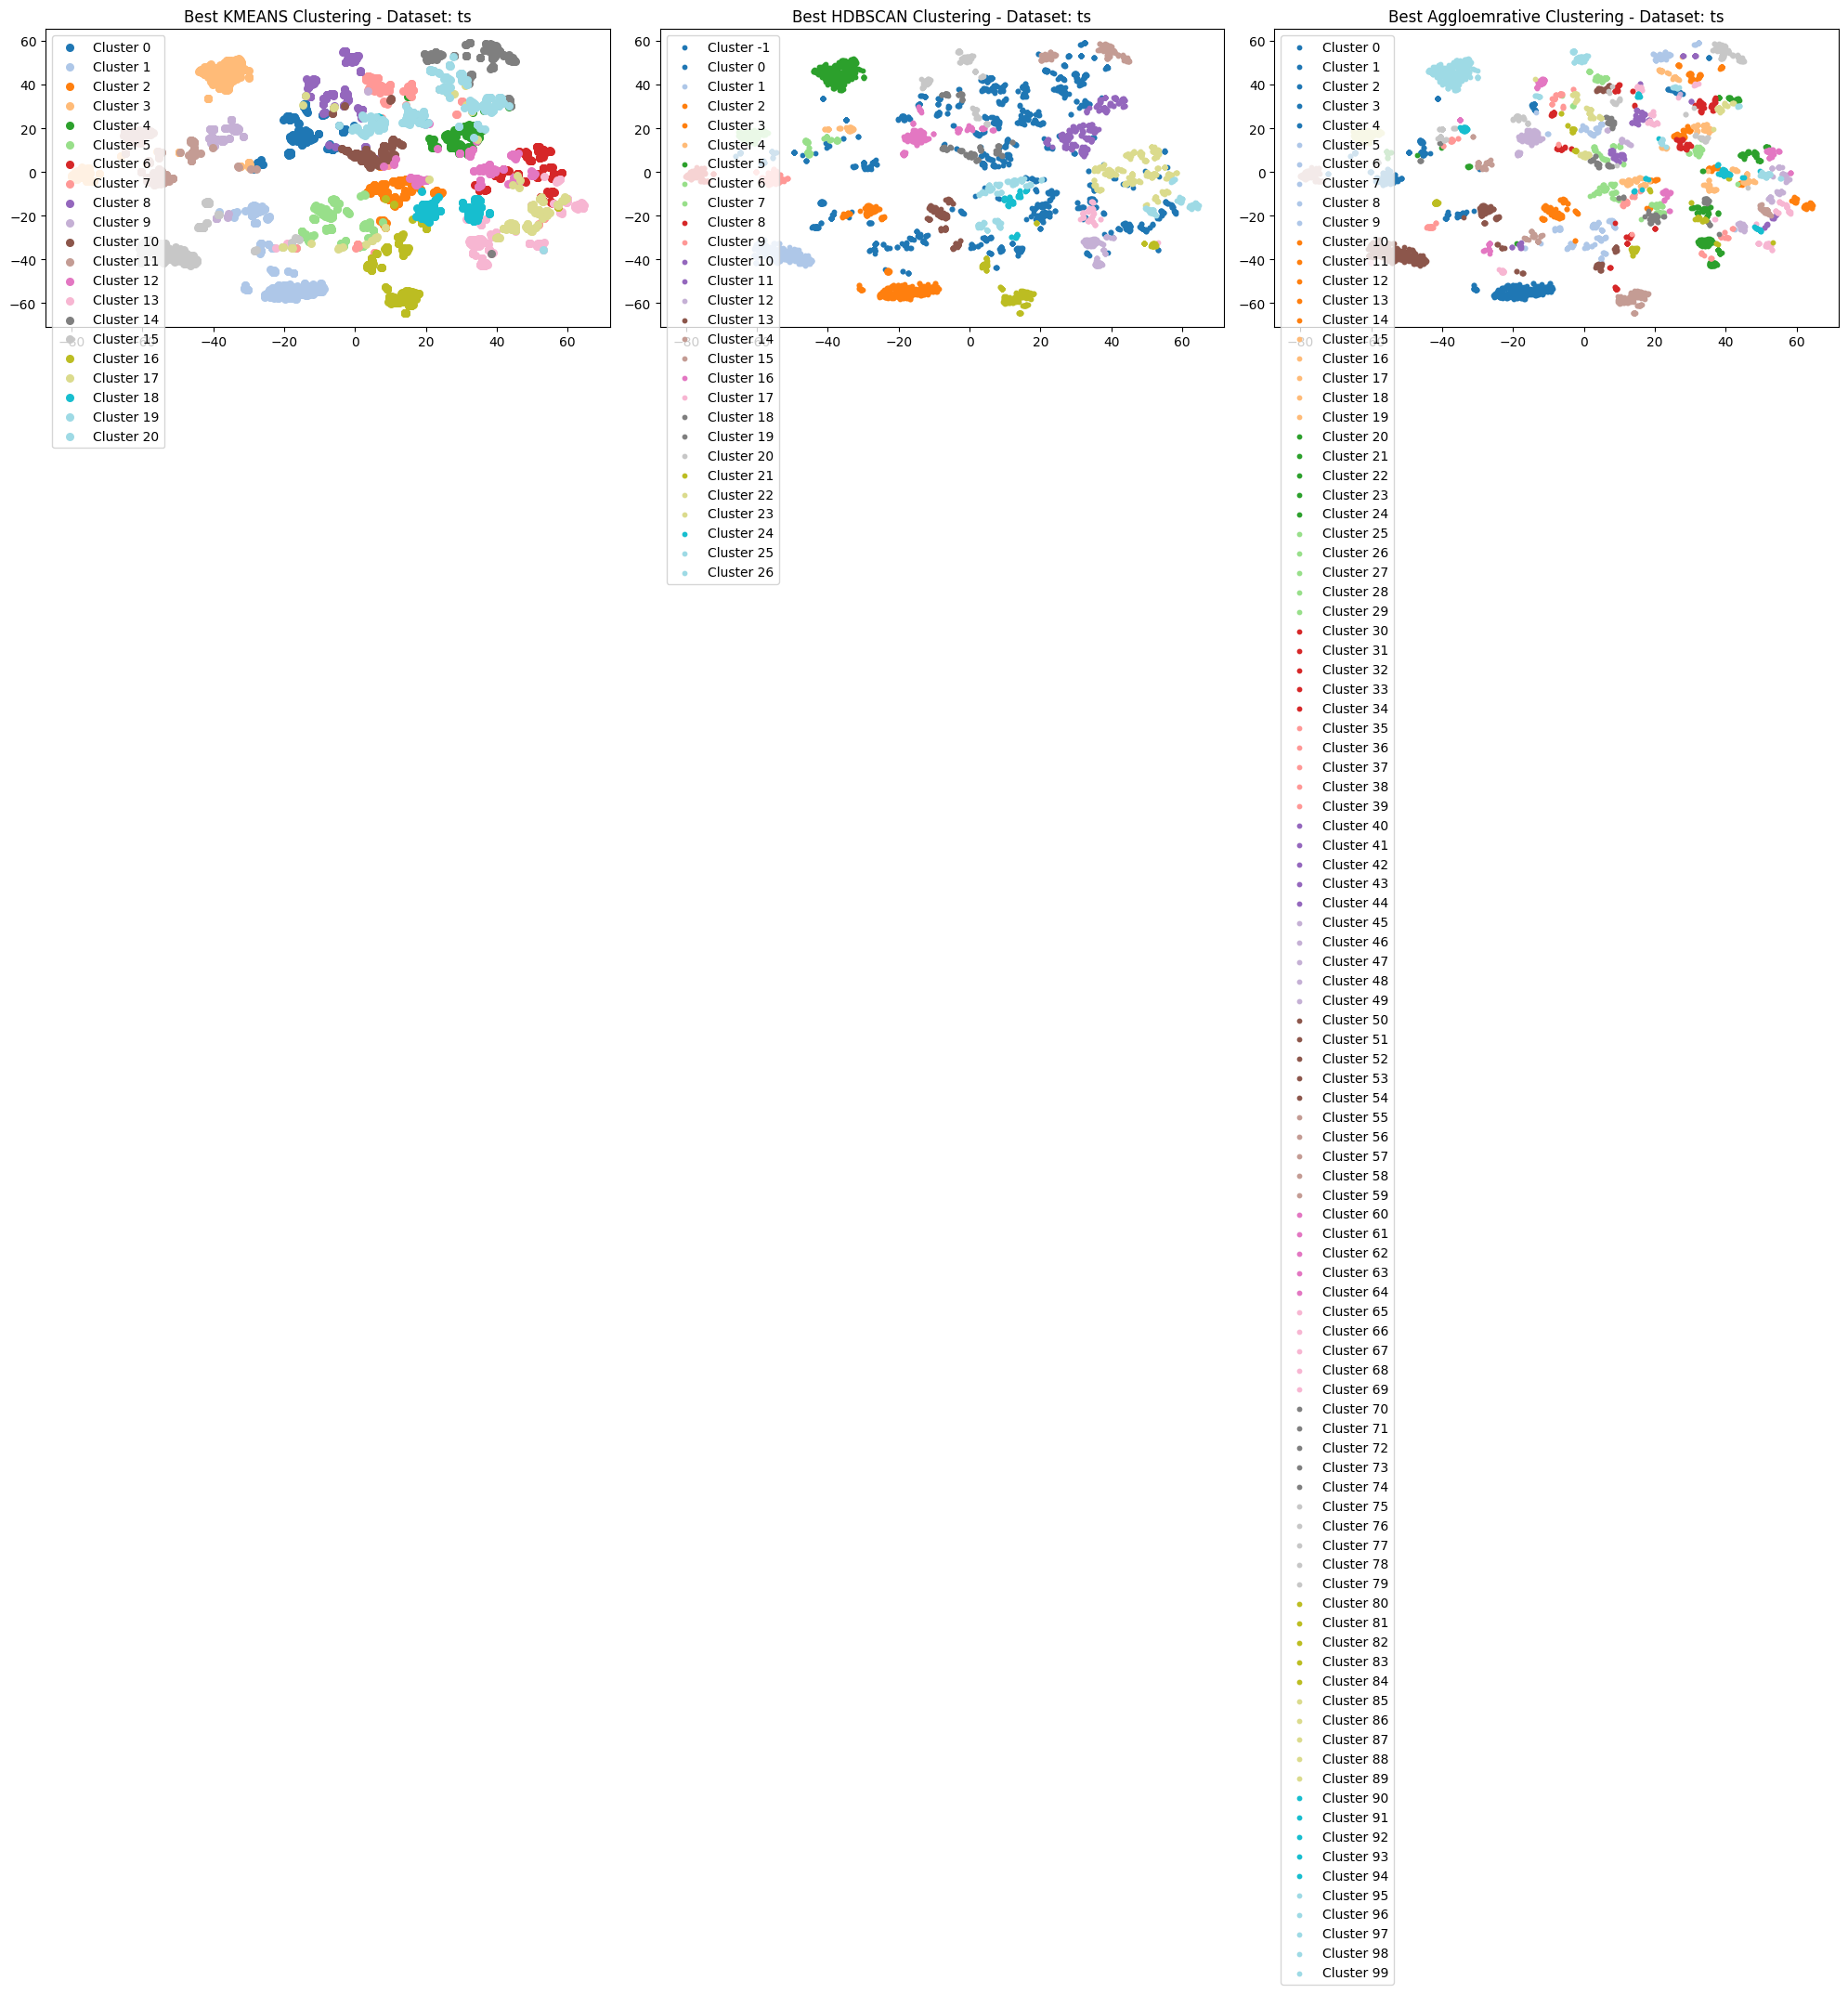

KMeans
SPectral
DBSCAN
{'min_cluster_size': 60, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: Agglomerative
13    706
2     572
6     566
8     475
7     444
12    394
11    389
1     351
9     350
10    341
4     286
14    250
5     247
0     216
3     197
dtype: int64
 4     592
 3     566
 1     559
 2     542
 12    522
 13    499
 10    390
 11    372
 0     300
 8     293
 5     245
 9     231
 7     227
-1     169
 6     167
 14    110
dtype: int64
4     566
10    558
14    354
2     248
22    245
11    245
1     243
32    215
6     199
3     180
13    176
20    174
33    152
15    148
16    132
18    131
8     129
24    129
0     128
21    124
9     120
26    109
5      96
7      94
17     91
27     82
19     72
30     70
38     70
34     66
35     63
36     56
12     53
29     51
25     45
28     45
37     37
31     34
23     29
39     25
dtype: int64


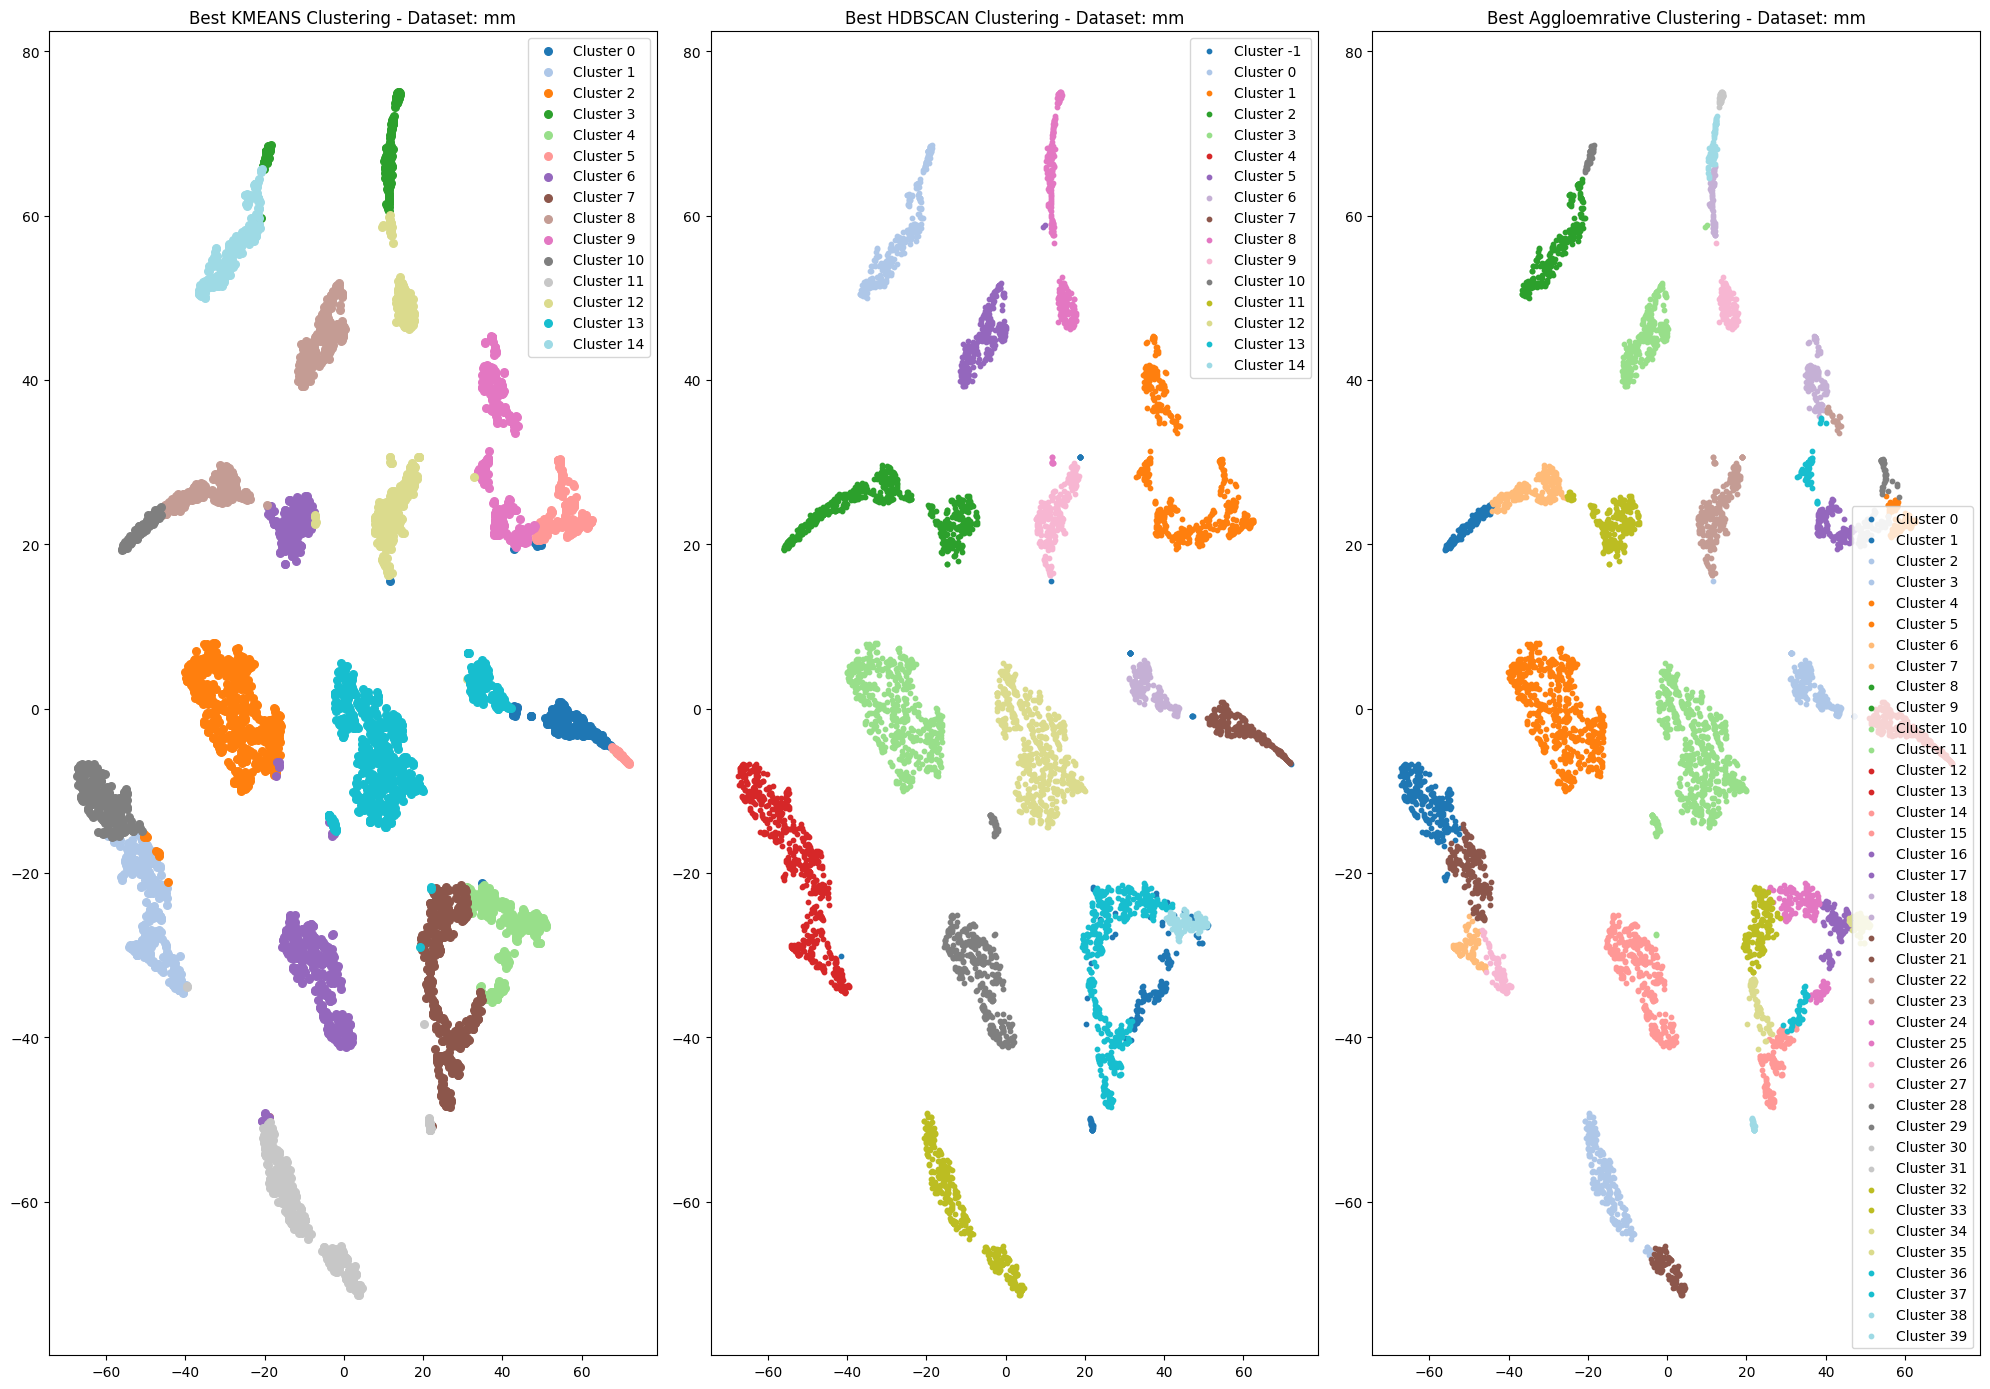

KMeans
SPectral
DBSCAN
{'min_cluster_size': 60, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: Agglomerative
5     518
0     469
13    434
7     428
8     406
11    374
4     365
14    354
16    322
2     299
12    264
17    217
1     197
9     190
18    176
6     175
10    169
15    149
19    139
3     139
dtype: int64
-1    3032
 0    2022
 2     496
 1     234
dtype: int64
0    2563
1    1985
2    1236
dtype: int64


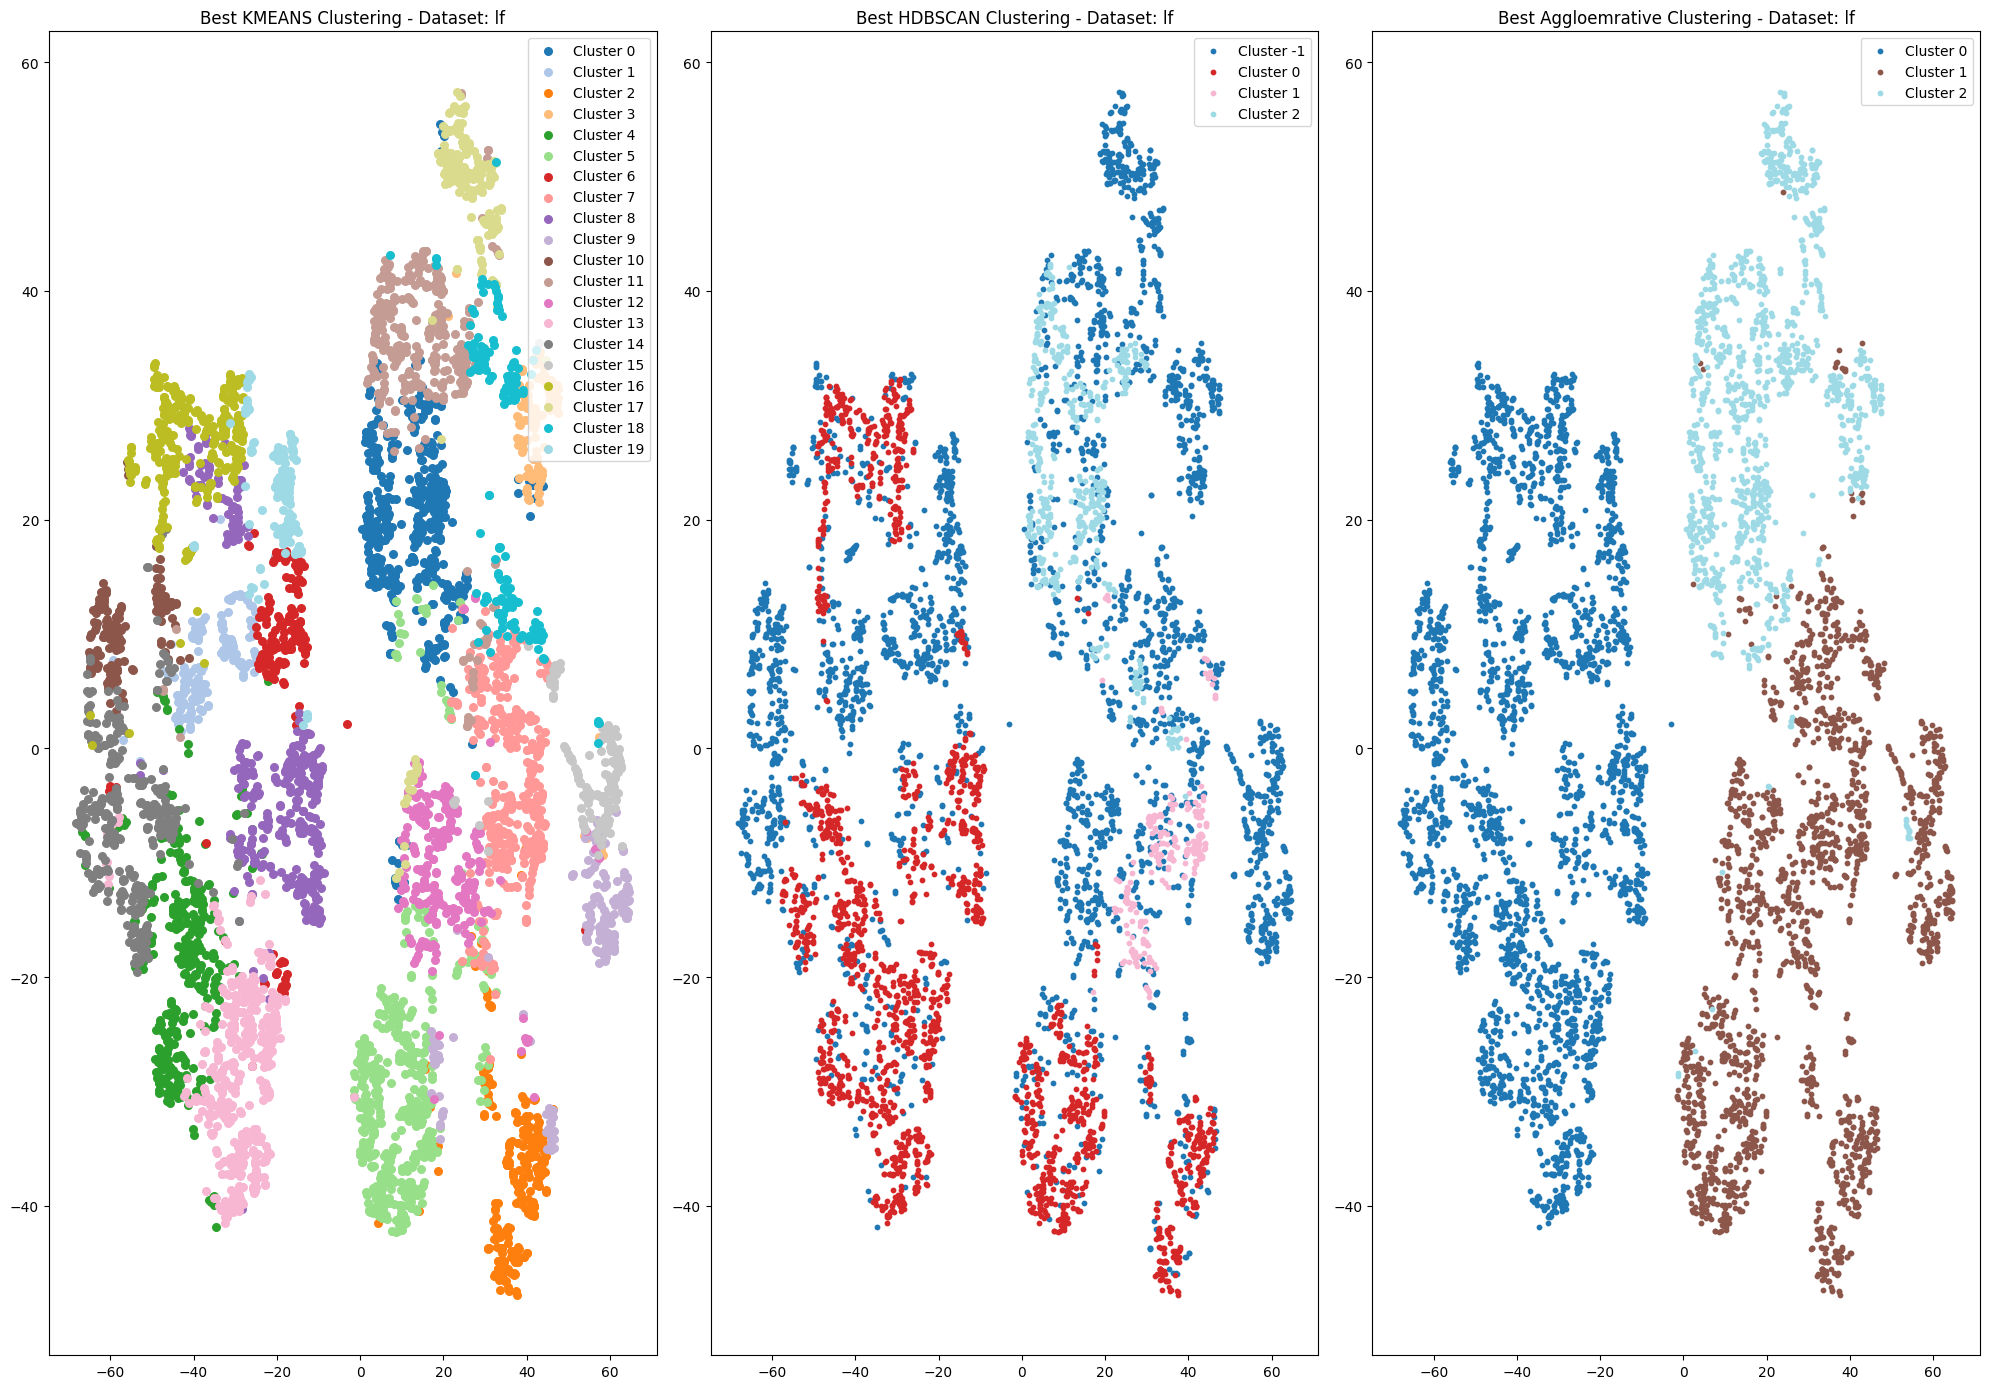

In [12]:
latent_late_fusion = Concatenate()([latent_ts, latent_st])
latent_late_fusion = np.array(latent_late_fusion)
#average_late_fusion = Concatenate()([average_encoded_static, average_encoded_static])
#average_late_fusion = np.array(average_late_fusion)
data = [latent_st, latent_ts, latent_mm, latent_late_fusion]
#average_encoded_static, average_encoded_time_series, average_encoded_mm, average_late_fusion
#latent_st, latent_ts, latent_mm, latent_late_fusion
dataset_name = ['st', 'ts', 'mm', 'lf']
#'st', 'ts', 'mm', 'lf'
#'encoded_static', 'encoded_time_series', 
# data = [encoded_mm, encoded_late_fusion]

results = pd.DataFrame()
best_labels = pd.DataFrame()
all_labels = pd.DataFrame()
for i, y in zip(data, dataset_name):
    df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=100)

    df_results.index = [y, y, y]

    y = f'{y}_{best_model}'
    labels_ = pd.Series(best_labels_, name=y)
    best_labels = pd.concat([best_labels, labels_], axis=1)
    all_labels = pd.concat([all_labels, labels_df], axis=1)
    

    #results = results.append(df_results)
    results = pd.concat([results, df_results])

In [14]:
results

,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
st,KMeans,0.265652,1.180373,1387.169426
st,HDBSCAN,0.218393,2.553022,1107.191304
st,Agglomerative,0.288975,1.333703,2177.856773
ts,KMeans,0.289413,1.466823,1048.590623
ts,HDBSCAN,0.230512,1.478643,399.085930
ts,Agglomerative,0.462531,1.191482,584.873520
mm,KMeans,0.483907,0.710744,5941.382243
mm,HDBSCAN,0.401228,1.313601,3380.993399
mm,Agglomerative,0.537424,0.667319,8602.965823
lf,KMeans,0.192021,1.419730,949.291859


## Cluster Stability

In [15]:
best_labels.columns

Index(['st_Agglomerative', 'ts_Agglomerative', 'mm_Agglomerative',
       'lf_Agglomerative'],
      dtype='object')

In [16]:
all_labels.columns

Index(['st_KMeans', 'st_HDBSCAN', 'st_Agglomerative', 'ts_KMeans',
       'ts_HDBSCAN', 'ts_Agglomerative', 'mm_KMeans', 'mm_HDBSCAN',
       'mm_Agglomerative', 'lf_KMeans', 'lf_HDBSCAN', 'lf_Agglomerative'],
      dtype='object')

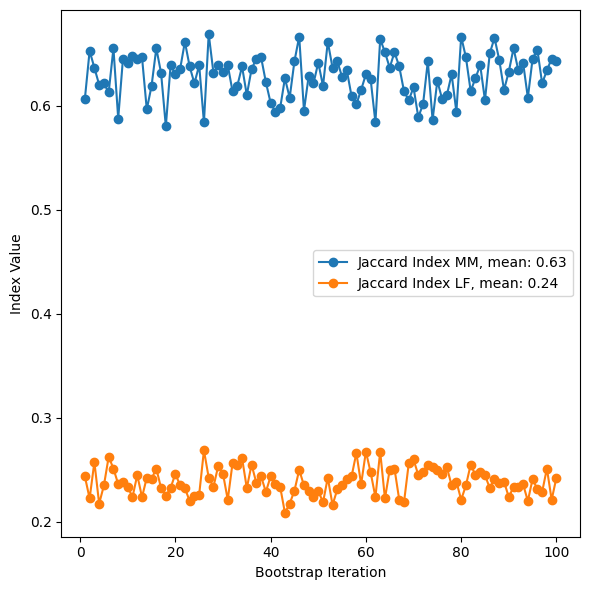

In [17]:
plt.style.use('default')
# Perform cluster stability analysis using Spectral
labels_ = ['mm_HDBSCAN']
jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 40, 'agglomerative', num_iterations=100)
mean_jaccard_mm = np.mean(jaccard_indices_mm)

labels_ = ['lf_KMeans']
# Perform cluster stability analysis using KMeans
jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values,3, 'agglomerative', num_iterations=100)
mean_jaccard_lf = np.mean(jaccard_indices_lf)

# Plotting ARI and Jaccard Index across the runs
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MM, mean: {0:.2}".format(mean_jaccard_mm), marker='o')
plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index LF, mean: {0:.2}".format(mean_jaccard_lf) , marker='o')
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()

plt.show()

## KM

In [18]:
sepsis3.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'mort_icu', 'mort_hosp', 'diagnosis',
       'sepsis_angus', 'sepsis_martin', 'sepsis_explicit',
       'septic_shock_explicit', 'severe_sepsis_explicit', 'sepsis_nqf',
       'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital', 'vent',
       'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score', 'composite_outcome', 'blood culture',
       'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2

In [19]:
best_labels.columns

Index(['st_Agglomerative', 'ts_Agglomerative', 'mm_Agglomerative',
       'lf_Agglomerative'],
      dtype='object')

mm_Agglomerative  thirtyday_expire_flag
0                 0                         94
                  1                         34
1                 0                        199
                  1                         44
2                 0                        212
                                          ... 
37                0                         33
                  1                          4
38                0                         44
                  1                         26
39                0                         25
Name: thirtyday_expire_flag, Length: 78, dtype: int64


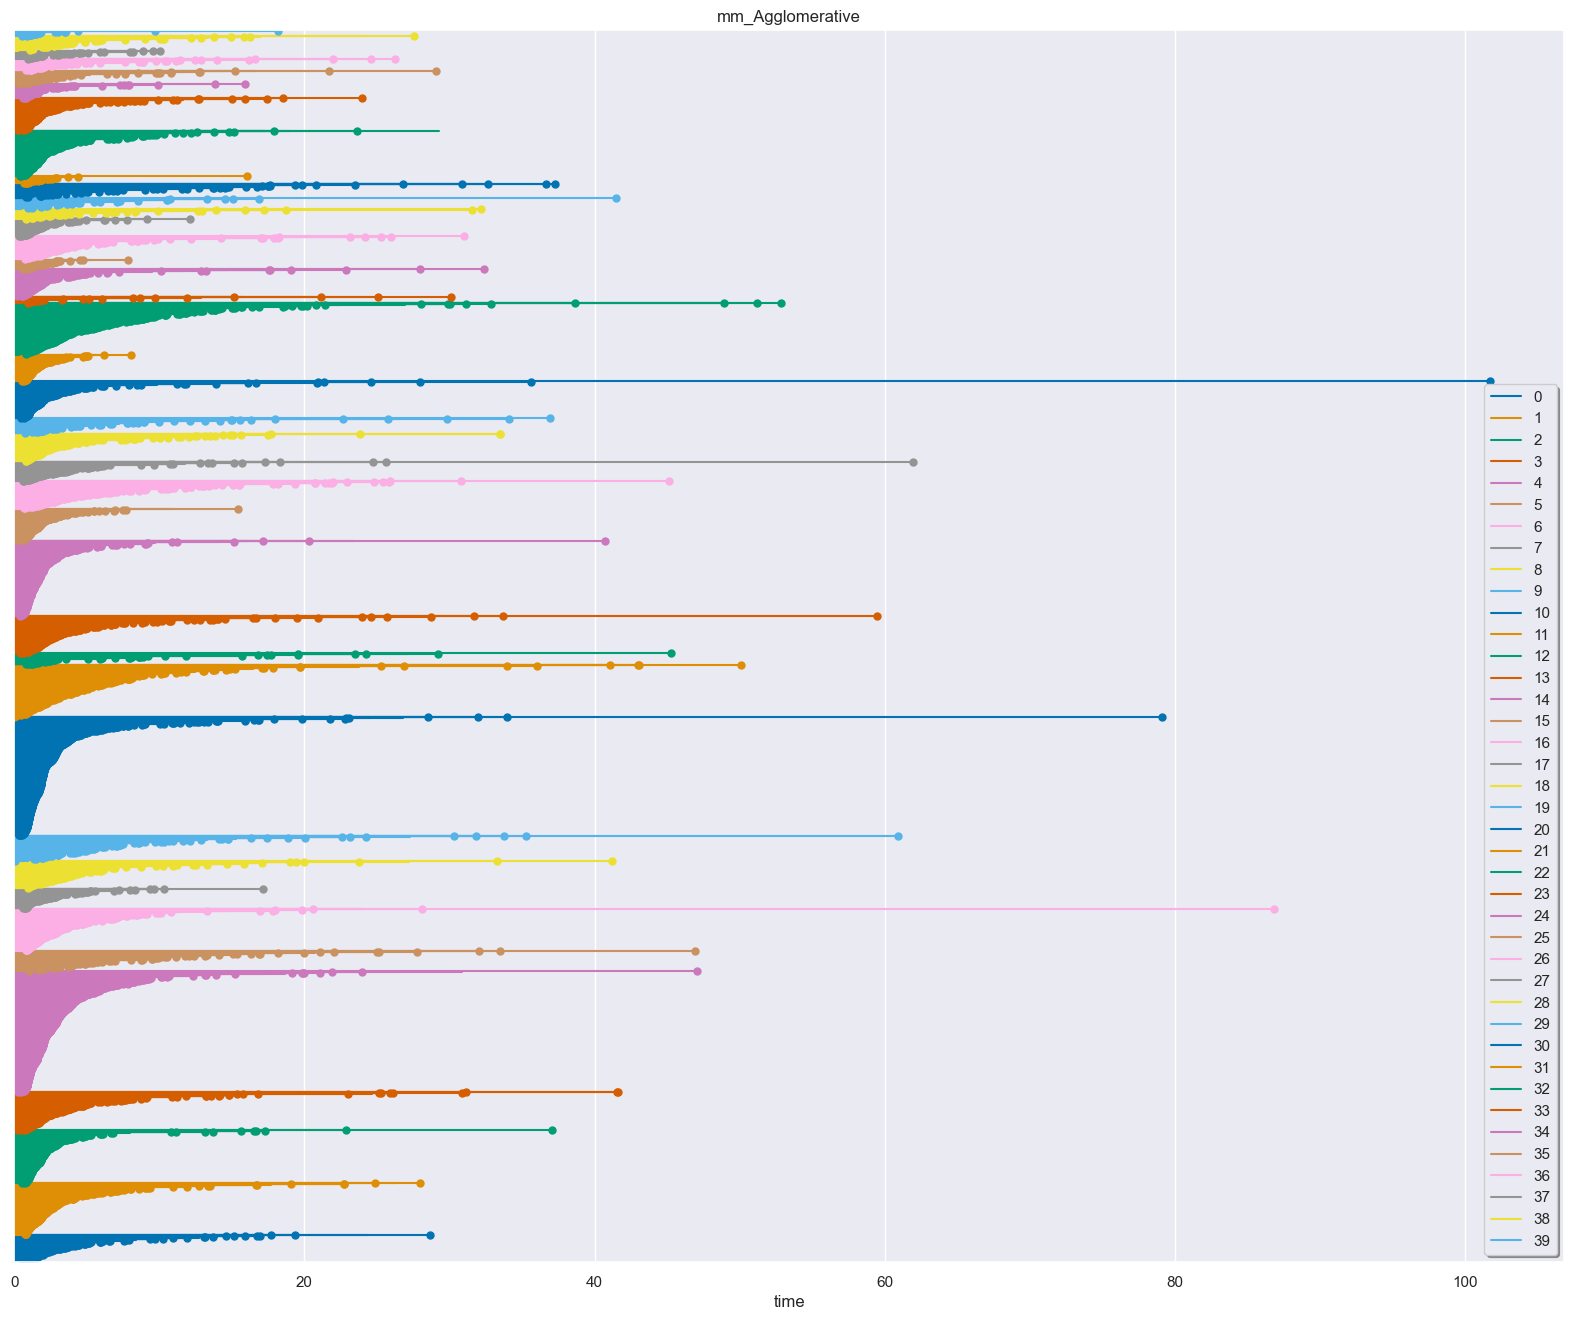

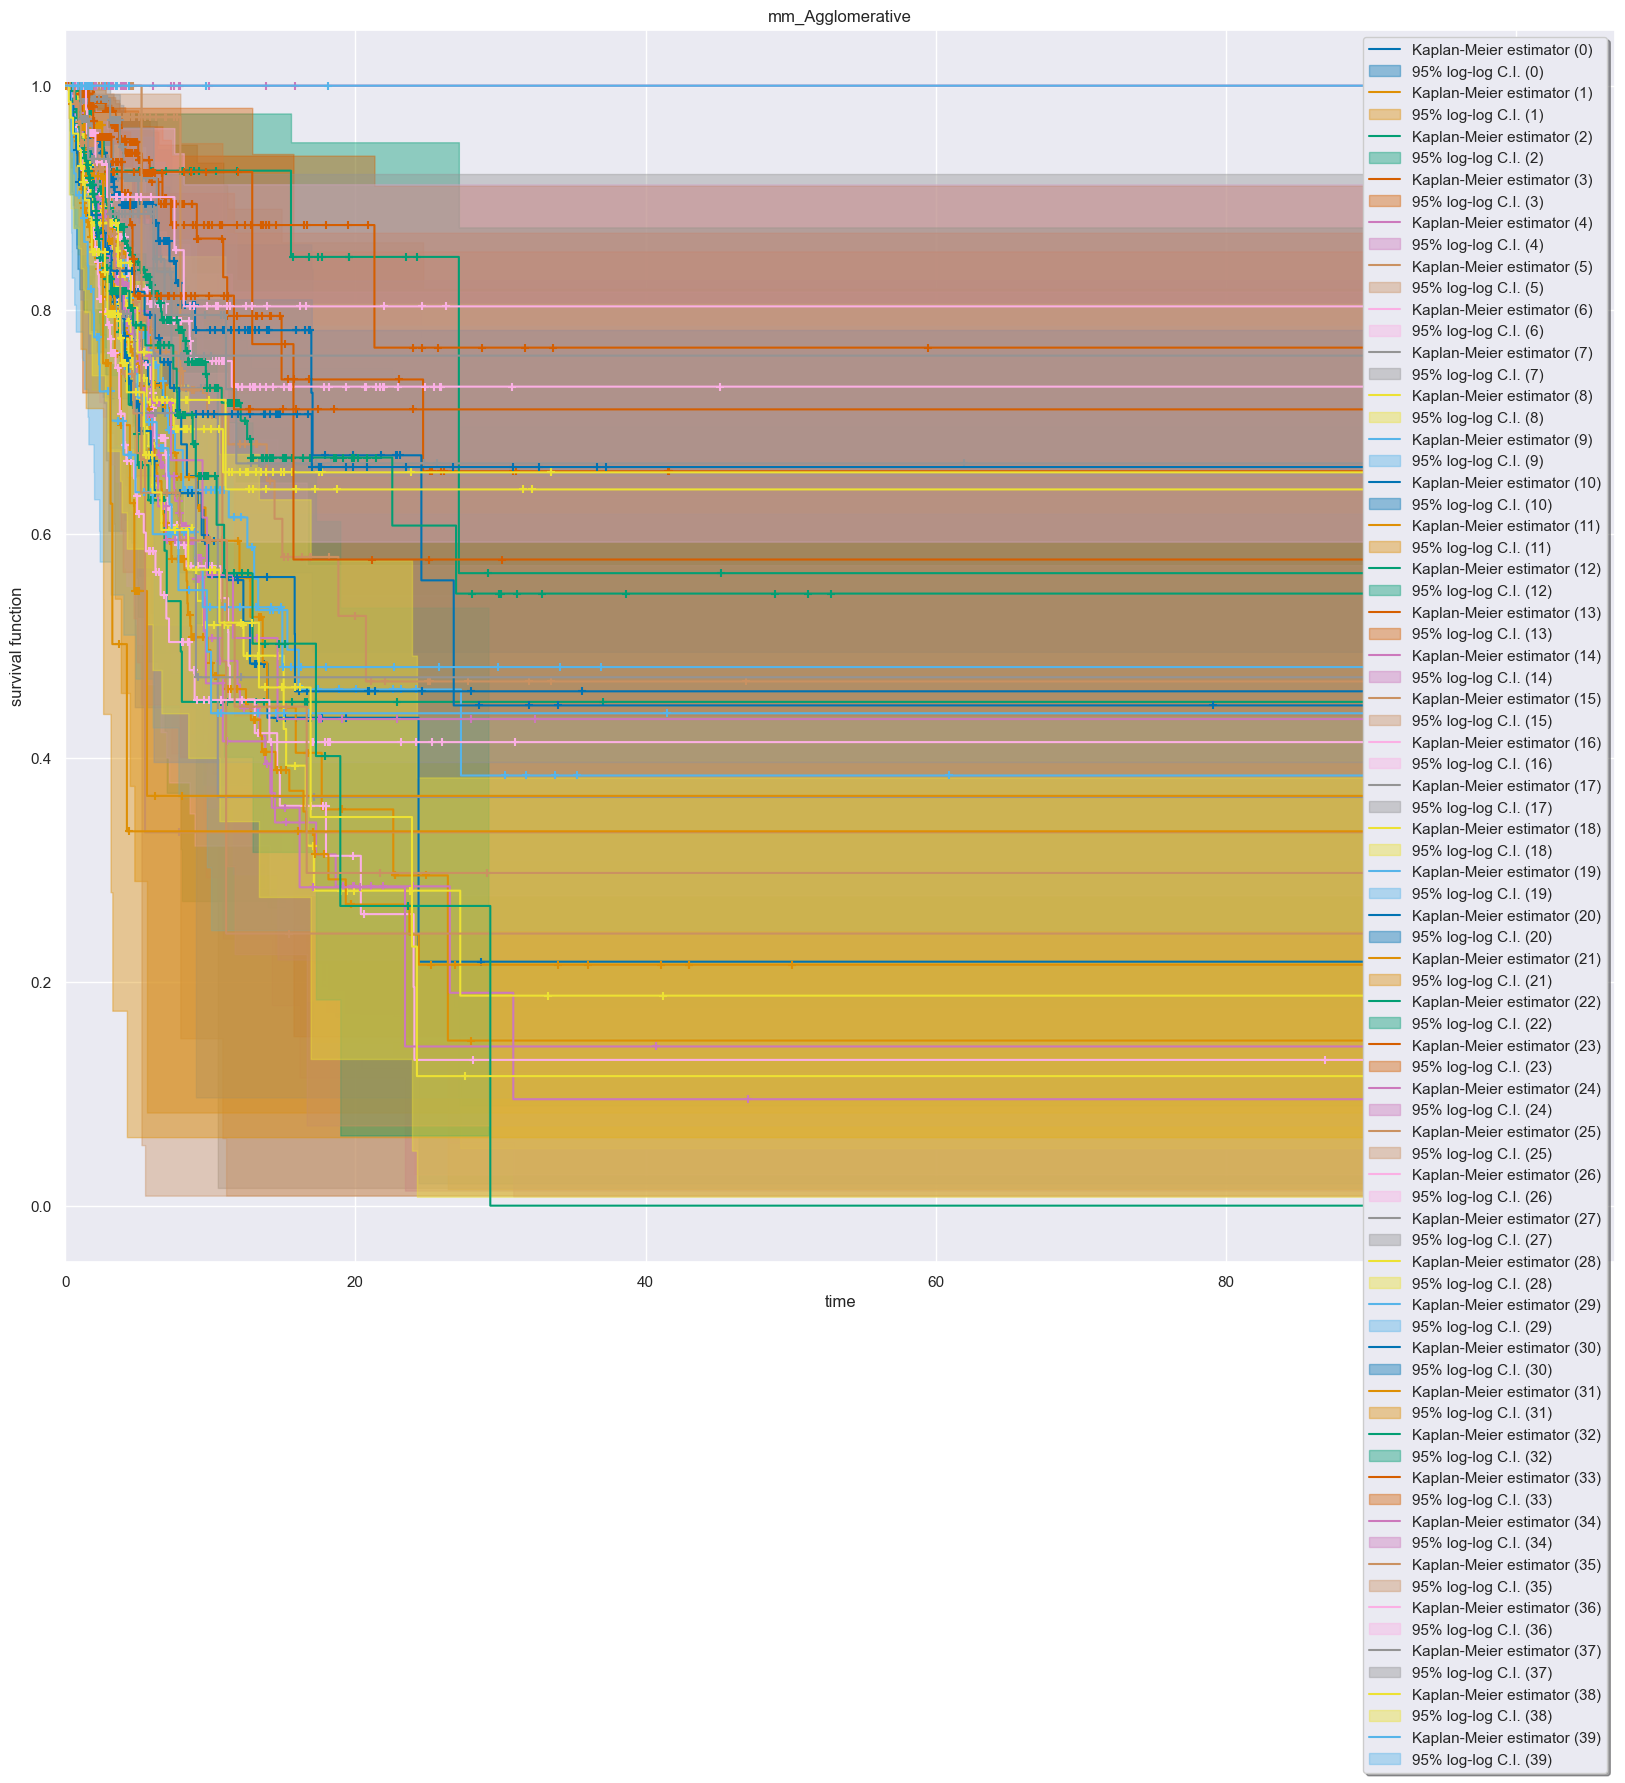

mm_Agglomerative


group,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
time,,,,,,,,,,,,,,,,,,,,,
1,0.959507,0.978468,0.995595,0.994083,0.981577,0.958220,0.979713,0.963909,0.953363,0.974790,...,0.913846,1.000000,0.951657,1.000000,1.0,0.967195,1.000000,1.000000,0.942857,1.0
3,0.820082,0.900189,0.842614,0.972734,0.870776,0.892817,0.862774,0.950139,0.872769,0.861660,...,0.852187,0.752066,0.827268,0.953989,1.0,0.867939,0.900518,0.934641,0.796490,1.0
5,0.774711,0.796627,0.688769,0.949930,0.735880,0.792992,0.775251,0.917375,0.735275,0.777227,...,0.815823,0.334252,0.785951,0.812541,1.0,0.671927,0.900518,0.885449,0.726233,1.0
10,0.593440,0.593665,0.449808,0.863505,0.506661,0.705861,0.570992,0.729730,0.518374,0.639086,...,0.706610,0.334252,0.651351,0.812541,1.0,0.594125,0.802938,0.758956,0.567842,1.0
30,0.217827,0.147415,0.449808,0.655715,0.190067,0.468047,0.130153,0.364865,0.187507,0.384084,...,0.659502,0.334252,0.000000,0.710974,1.0,0.297062,0.802938,0.758956,0.115671,1.0


In [20]:
labels_ = ['mm_Agglomerative']


sns.set(style="darkgrid", palette="colorblind", color_codes=True)



for modality in labels_:
    kmd = sepsis3.join(all_labels[modality])
    surv = SurvivalData(time="icu_los", status="thirtyday_expire_flag", group=modality, data=kmd)
    print(kmd.groupby(modality)['thirtyday_expire_flag'].value_counts())

    #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
    plt.figure(figsize=(20, 16))
    surv.plot_lifetimes()
    plt.title(modality)
    plt.show()
    plt.close()

    #kaplan meier
    km = KaplanMeier()
    km.fit(surv)

    #display(km.summary())
    # abulates the survival probability estimates and thier 
    # standard error and confidence intervals for the event times within each group. 
    # It can be printed to display all the information at once.
    #print(km.summary)
    plt.figure(figsize=(20, 16))
    km.plot()
    plt.title(modality)
    plt.show()
    plt.close()


    estimate = km.predict([1, 3, 5, 10, 30])
    # estimated probabiltiies for surviving past a certain time for each group.
    print(modality)
    display(estimate)

## Table1

In [67]:
from tableone import TableOne

ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)

table1 = TableOne(temp, dip_test=True, normal_test=True, tukey_test=True)
table1

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


,,Missing,Overall
n,,,5784
"hours_in, n (%)",11.5,0,5784 (100.0)
"aado2, mean (SD)",,4940,441.2 (133.6)
"baseexcess, mean (SD)",,1950,-1.7 (8.4)
"bicarbonate, mean (SD)",,13,23.2 (4.5)
"totalco2, mean (SD)",,1951,24.4 (5.6)
"carboxyhemoglobin, mean (SD)",,5596,2.2 (1.5)
"chloride, mean (SD)",,13,104.9 (6.2)
"calcium, mean (SD)",,3085,1.1 (0.1)
"glucose, mean (SD)",,3,164.0 (1461.9)


In [68]:
nonnormal = list(temp.columns)

In [69]:
table2 = TableOne(temp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)

table2

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                                                             Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                   26                   27                   28                   29                    3                   30                   31                   32                   33                   34                   35                   36                   37                   38                   39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                                    5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                   29                  129                   45                  109                   82                   45                   51                  180                   70                   34                  215                  152                   66                   63                   56                   37                   70                   25                  566                   96                  199                   94                  129                  120                                   
hours_in, median [Q1,Q3]            11.5                           0         5784 (100.0)          128 (100.0)          243 (100.0)          558 (100.0)          245 (100.0)           53 (100.0)          176 (100.0)          354 (100.0)          148 (100.0)          132 (100.0)           91 (100.0)          131 (100.0)           72 (100.0)          248 (100.0)          174 (100.0)          124 (100.0)          245 (100.0)           29 (100.0)          129 (100.0)           45 (100.0)          109 (100.0)           82 (100.0)           45 (100.0)           51 (100.0)          180 (100.0)           70 (100.0)           34 (100.0)          215 (100.0)          152 (100.0)           66 (100.0)           63 (100.0)           56 (100.0)           37 (100.0)           70 (100.0)           25 (100.0)          566 (100.0)           96 (100.0)          199 (100.0)           94 (100.0)          129 (100.0)          120 (100.0)              1.000     Chi-squared
aado2, median [Q1,Q3]                                           4940  459.0 [341.0,556.8]  508.0 [375.8,552.5]  480.0 [433.5,599.9]  519.0 [407.8,575.0]  436.5 [311.0,510.0]  402.0 

In [70]:
t2 = table2.tableone
t2.columns = t2.columns.droplevel()
t2 = t2.replace(to_replace='<', value='', regex=True)

t2["P-Value (adjusted)"] = pd.to_numeric(t2["P-Value (adjusted)"], errors='coerce', downcast="float")

t2[t2['P-Value (adjusted)']<=0.05]

,,Missing,Overall,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,5,6,7,8,9,P-Value (adjusted),Test
"baseexcess, median [Q1,Q3]",,1950,"-1.0 [-4.0,1.0]","-0.6 [-3.0,1.8]","-1.0 [-4.1,1.9]","-1.3 [-5.0,1.0]","-1.2 [-5.2,1.0]","-2.0 [-5.9,1.0]","-0.9 [-3.2,0.6]","-1.0 [-4.0,1.3]","-0.3 [-2.5,1.0]","-1.1 [-4.2,1.6]","0.0 [-3.5,2.0]","-0.7 [-2.7,0.5]","-1.7 [-5.2,-0.2]","-1.0 [-3.0,0.8]","0.0 [-3.1,1.0]","0.0 [-1.0,1.0]","-1.4 [-5.5,0.7]","0.3 [-2.1,1.9]","-1.0 [-5.2,1.9]","-1.0 [-2.0,1.0]","-2.7 [-7.0,0.3]","0.4 [-0.4,1.8]","-0.3 [-2.1,0.5]","-1.3 [-3.6,0.3]","-1.5 [-4.5,0.1]","-2.0 [-7.1,0.7]","0.0 [-1.5,1.7]","-0.8 [-3.2,1.0]","-1.4 [-5.0,0.6]","-1.0 [-2.8,1.0]","-1.0 [-6.2,1.0]","-0.8 [-3.3,1.0]","0.7 [-0.5,2.0]","-1.0 [-2.6,0.6]","-1.0 [-2.0,0.0]","-0.6 [-3.6,2.0]","-2.7 [-6.5,0.8]","-0.4 [-3.6,2.0]","0.0 [-1.8,2.8]","-0.7 [-3.6,0.6]","-2.7 [-6.6,0.0]",0.001,Kruskal-Wallis
"bicarbonate, median [Q1,Q3]",,13,"23.3 [20.5,26.0]","23.8 [20.5,26.5]","23.0 [20.5,26.7]","22.5 [19.5,25.0]","23.0 [19.5,26.3]","23.0 [19.0,25.0]","23.5 [21.5,25.5]","23.3 [21.0,25.3]","24.0 [22.5,26.1]","23.3 [20.5,25.7]","23.3 [21.2,26.2]","24.0 [22.0,25.7]","21.7 [19.5,24.0]","22.7 [20.7,25.3]","23.8 [21.0,25.7]","23.7 [22.2,25.5]","22.2 [19.3,25.0]","25.0 [22.8,27.0]","23.3 [19.6,25.5]","25.0 [22.5,27.0]","22.0 [18.7,25.0]","24.6 [22.4,27.0]","23.6 [21.7,26.5]","23.5 [21.5,25.2]","23.0 [19.8,25.5]","23.0 [18.6,25.9]","25.2 [21.9,26.6]","23.2 [20.5,25.5]","23.0 [20.0,25.5]","23.0 [21.3,25.5]","22.0 [17.9,25.0]","23.0 [21.7,25.0]","24.5 [23.5,25.8]","23.0 [21.0,25.5]","24.0 [22.5,25.0]","24.0 [21.2,26.5]","22.0 [19.2,24.8]","24.0 [20.7,27.0]","24.0 [22.0,27.5]","23.7 [21.0,25.5]","21.0 [19.0,24.7]",0.001,Kruskal-Wallis
"totalco2, median [Q1,Q3]",,1951,"24.2 [21.0,27.2]","24.4 [21.2,28.0]","24.0 [21.0,28.5]","23.8 [20.0,27.0]","23.8 [19.8,27.2]","23.5 [19.7,26.5]","24.6 [22.2,27.0]","24.3 [21.2,26.9]","25.0 [22.0,27.0]","24.5 [21.8,27.0]","25.2 [22.5,29.8]","24.5 [23.0,27.3]","23.1 [20.1,25.1]","24.2 [21.4,26.8]","25.0 [22.7,27.0]","25.7 [23.0,27.1]","23.7 [20.3,26.5]","26.6 [23.9,28.5]","24.2 [19.0,27.7]","24.0 [22.0,27.0]","22.5 [18.7,26.5]","26.0 [25.2,28.0]","25.4 [23.2,26.5]","24.2 [21.5,25.6]","24.0 [20.9,26.0]","24.0 [19.4,27.0]","26.0 [23.5,28.0]","24.5 [21.0,27.2]","24.0 [20.2,26.4]","24.0 [23.0,26.6]","22.8 [19.1,27.2]","25.0 [22.8,27.9]","27.0 [25.0,28.4]","24.2 [21.8,27.1]","25.2 [22.0,26.4]","25.0 [21.7,28.6]","23.4 [19.6,27.8]","24.7 [20.5,29.0]","26.0 [22.5,28.8]","24.6 [21.7,27.0]","22.6 [19.8,26.0]",0.001,Kruskal-Wallis
"chloride, median [Q1,Q3]",,13,"105.0 [101.5,108.5]","105.3 [101.0,108.5]","103.0 [99.1,107.2]","105.5 [101.7,108.7]","106.0 [101.3,109.5]","106.0 [102.2,108.0]","105.4 [102.1,108.5]","105.0 [101.5,108.5]","104.0 [101.0,107.0]","105.2 [100.5,108.8]","102.5 [98.5,106.1]","106.0 [103.8,108.4]","107.0 [103.7,110.3]","104.5 [101.2,108.7]","104.5 [101.7,107.5]","105.0 [101.9,107.1]","107.0 [103.5,110.0]","104.8 [103.3,106.9]","102.0 [98.5,106.0]","105.0 [102.7,107.0]","107.7 [104.0,111.5]","105.1 [102.5,107.0]","106.5 [104.6,108.3]","105.8 [104.4,108.2]","106.0 [102.3,110.0]","105.2 [100.2,107.5]","106.1 [103.5,108.4]","106.6 [103.5,110.3]","103.5 [99.9,107.5]","106.2 [102.5,108.7]","101.7 [98.0,104.8]","105.0 [103.5,107.4]","105.0 [101.5,107.0]","105.5 [102.9,108.8]","105.7 [104.0,109.0]","104.0 [100.0,107.3]","106.0 [100.0,109.8]","105.5 [100.6,109.0]","103.8 [100.5,108.0]","106.0 [103.4,108.8]","105.4 [102.2,108.3]",0.001,Kruskal-Wallis
"calcium, median [Q1,Q3]",,3085,"1.1 [1.1,1.1]","1.1 [1.1,1.2]","1.1 [1.1,1.2]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.1,1.2]","1.1 [1.1,1.2]","1.1 [1.0,1.1]","1.1 [1.1,1.2]","1.1 [1.0,1.1]","1.1 [1.0,1.2]","1.1 [1.1,1.1]","1.2 [1.1,1.2]","1.1 [1.1,1.1]","1.1 [1.1,1.2]","1.1 [1.0,1.1]","1.1 [1.0,1.1

In [71]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table 

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
                                                                 Missing      Overall            0            1           10           11          12           13           14           15           16          17           18          19            2           20           21           22          23           24          25           26          27          28          29            3          30          31           32           33          34          35          36          37          38          39            4           5            6           7            8            9 P-Value (adjusted)                                       Test
n                                                                                5784          128          243          558          245          53          176          354          148          132          91          131          72          248          174          124          245          29          129          45          109          82          45          51          180          70          34          215          152          66          63          56          37          70          25          566          96          199          94          129          120                                                              
vent, n (%)                              0.0                           0  3002 (51.9)    48 (37.5)   188 (77.4)   432 (77.4)    54 (22.0)   14 (26.4)    51 (29.0)   292 (82.5)   126 (85.1)      8 (6.1)   61 (67.0)     10 (7.6)   11 (15.3)   192 (77.4)   136 (78.2)   105 (84.7)     19 (7.8)     2 (6.9)    96 (74.4)   37 (82.2)    24 (22.0)   63 (76.8)     2 (4.4)     2 (3.9)    43 (23.9)     4 (5.7)    8 (23.5)   104 (48.4)   108 (71.1)   42 (63.6)   43 (68.3)     2 (3.6)   26 (70.3)    9 (12.9)   15 (60.0)   439 (77.6)     6 (6.2)    79 (39.7)   79 (84.0)      9 (7.0)    13 (10.8)             <0.001                                Chi-squared
                                         1.0                              2782 (48.1)    80 (62.5)    55 (22.6)   126 (22.6)   191 (78.0)   39 (73.6)   125 (71.0)    62 (17.5)    22 (14.9)   124 (93.9)   30 (33.0)   121 (92.4)   61 (84.7)    56 (22.6)    38 (21.8)    19 (15.3)   226 (92.2)   27 (93.1)    33 (25.6)    8 (17.8)    85 (78.0)   19 (23.2)   43 (95.6)   49 (96.1)   137 (76.1)   66 (94.3)   26 (76.5)   111 (51.6)    44 (28.9)   24 (36.4)   20 (31.7)   54 (96.4)   11 (29.7)   61 (87.1)   10 (40.0)   127 (22.4)   90 (93.8)   120 (60.3)   15 (16.0)   120 (93.0)   107 (89.2)                                                              
F, n (%)                                 0.0                           0  3221 (55.7)  128 (100.0)  243 (100.0)                   1 (0.4)  53 (100.0)   174 (98.9)      1 (0.3)  148 (100.0)  132 (100.0)  91 (100.0)  131 (100.0)   45 (62.5)  248 (100.0)  174 (100.0)  124 (100.0)               29 (100.0)  129 (100.0)  45 (100.0)               82 (100.0)  45 (100.0)  51 (100.0)     17 (9.4)  70 (100.0)  34 (100.0)    92 (42.8)   150 (98.7)  66 (100.0)  63 (100.0)  56 (100.0)  37 (100.0)  70 (100.0)  25 (100.0)               96 (100.0)    28 (14.1)  94 (100.0)  129 (100.0)  120 (100.0)             <0.001                                Chi-squared
                                         1.0                              2563 (44.3)                            558 (100.0)   244 (99.6)        

In [72]:
hd_labels.value_counts()

mm_Agglomerative
4                   566
10                  558
14                  354
2                   248
11                  245
22                  245
1                   243
32                  215
6                   199
3                   180
13                  176
20                  174
33                  152
15                  148
16                  132
18                  131
8                   129
24                  129
0                   128
21                  124
9                   120
26                  109
5                    96
7                    94
17                   91
27                   82
19                   72
38                   70
30                   70
34                   66
35                   63
36                   56
12                   53
29                   51
28                   45
25                   45
37                   37
31                   34
23                   29
39                   25
dtype: int64

## Spider Plots

In [ ]:
def create_spider_plot(categories, values, cluster_names):
    """
    Create a spider plot to visualize cluster counts for different variables.

    Parameters:
    - categories (list): List of variable categories.
    - values (list of arrays): Cluster values for each category.
    - cluster_names (list): Names for different clusters.

    Returns:
    None

    Example:
    create_spider_plot(
        categories=['Category1', 'Category2', 'Category3'],
        values=[[10, 15, 20], [5, 10, 15]],
        cluster_names=['Cluster A', 'Cluster B']
    )
    """
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    values = np.array(values)
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    plt.xticks(angles, categories)

    for i, (cluster_name, cluster_values) in enumerate(zip(cluster_names, values)):
        ax.plot(angles, cluster_values, label=cluster_name)
        ax.fill(angles, cluster_values, alpha=0.25)

    ax.set_yticklabels([])
    ax.legend()
    plt.title("Cluster Counts for Each Variable")
    plt.show()


In [ ]:
static.join(best_labels[labels_]).groupby(labels_).sum()


In [23]:
best_labels.index = static.index

In [24]:
# Female: 10, 12, 3, 5, 6, 9 
# Male: 0, 1, 11, 13, 14, 4, 7 
# Mix:  2, 6, 8

In [25]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

NameError: name 'create_spider_plot' is not defined

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
static.columns

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
best_labels[labels_].value_counts()
temp_ = time_series_2d_df
temp_

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

## DT

In [ ]:
time_series_3d_df = time_series_3d_df.set_index('icustay_id')

In [ ]:
static = static.astype(int)
columns = np.concatenate((static.columns, time_series_3d_df.columns), axis=None)
# Combine binary and continuous features
data = np.concatenate((static.values, time_series_3d_df.groupby('icustay_id').mean().values), axis=1)
mixed_data = pd.DataFrame(data, columns = columns)

In [ ]:
lab = best_labels[labels_]
data.index  = lab.index
df = data.join(lab)
df = df.fillna(-10)
#to_predict  = mort_icu.mort_icu

to_predict  = sepsis3.is_male
X, y = df.values, to_predict
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7, stratify=y)
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=6)
clf = clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1_weighted')

scores


In [ ]:
pd.DataFrame(clf.feature_importances_, index = df.columns, columns = ['FI']).sort_values(by='FI', ascending=False).head(30)

In [ ]:
print("%0.2f f1 weighted with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
y_pred_test = clf.predict(x_test)
y_pred_train = clf.predict(x_train)
accuracy_score(y_test, y_pred_test)

In [ ]:
f1_score(y_test, y_pred_test, average='weighted')

In [ ]:
plt.figure(figsize=(40,30))
#c = ['-1','0','1','2','3']
#c = ['-1','0','1','2','3', '4','5','6','7','8','9','10','11', '12']

c = ['0','1']

tree.plot_tree(clf, filled=True, class_names=c, feature_names=df.columns, fontsize=6)
plt.show()